# Character-Level Language Modeling with RNN

In this tutorial we are going to learn to generate text using a character-based RNN. We will use a toy dataset, which consists dinosaur names, to generate new and unique dinosaur names. This toy example may not have many practical applications, but it can be used to learn fundamentals, which can then be applied to a more challenging real world problem. So, let us get started by reviewing the goals and outline of this tutorial:

After this tutorial you will understand:
* Preparing dataset for the RNN
* Building a RNN in TensorFlow
* Generating text using the trained RNN
* Customizing training loop in TensorFlow

This tutorial is Jupyter notebook styled, so that you can follow the code or even run it in a browser. You can find all the necessary things needed to learn from this tutorial here.

In [1]:
# Let us import some libraries

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time

Let us get started by reading the data file.

## Exploring the dataset

In [2]:
# Read in the text
text = open('dinos.txt', 'rb').read().decode(encoding='utf-8')

In [3]:
print ('Length of text: {} characters'.format(len(text)))

Length of text: 19913 characters


Let us see what the text looks like, by printing first 100 characters of the text.

In [4]:
print(text[:100])

Aachenosaurus
Aardonyx
Abdallahsaurus
Abelisaurus
Abrictosaurus
Abrosaurus
Abydosaurus
Acanthopholis


Let us now see the unique characters in the file.

In [5]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

53 unique characters


Let us plot the word length distribution in the text.

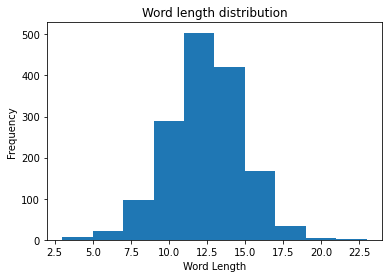

In [6]:
words = text.split('\n')
lengths = []
for word in words:
    lengths.append(len(word))

plt.hist(lengths)
plt.title('Word length distribution')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

We see that most of the words are of length 12 or 13. Let us find the length of the longest name.

In [7]:
max_length = max(lengths)
print(f'max length: {max_length}')

max length: 23


## Process the text

As the first preprocessing step we will pad the words to make them of the same length. We choose the new line character for the same.

In [8]:
padding_char = '\n'    # declaring the padding character
text = ''              # stores the processed text

for word in words:
    # For each word, add it to the text, and add appropriate padding
    text = text + word + padding_char * (1 + max_length - len(word))

text[:100]

'Aachenosaurus\n\n\n\n\n\n\n\n\n\n\nAardonyx\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAbdallahsaurus\n\n\n\n\n\n\n\n\n\nAbelisaurus\n\n\n\n\n\n\n\n\n\n\n\n\nAbri'

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [9]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Now we have an integer representation for each character. Notice that we mapped the character as indexes from 0 to `len(unique)`.

In [10]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  'A' :   1,
  'B' :   2,
  'C' :   3,
  'D' :   4,
  'E' :   5,
  'F' :   6,
  'G' :   7,
  'H' :   8,
  'I' :   9,
  'J' :  10,
  'K' :  11,
  'L' :  12,
  'M' :  13,
  'N' :  14,
  'O' :  15,
  'P' :  16,
  'Q' :  17,
  'R' :  18,
  'S' :  19,
  ...
}


In [11]:
text_as_int[:100]

array([ 1, 27, 29, 34, 31, 40, 41, 45, 27, 47, 44, 47, 45,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1, 27, 44, 30, 41, 40, 51, 50,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 28, 30,
       27, 38, 38, 27, 34, 45, 27, 47, 44, 47, 45,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1, 28, 31, 38, 35, 45, 27, 47, 44, 47, 45,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 28, 44, 35])

In [12]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'Aachenosaurus' ---- characters mapped to int ---- > [ 1 27 29 34 31 40 41 45 27 47 44 47 45]


## The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

## Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain seq_length characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of seq_length+1. For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) function to convert the text vector into a stream of character indices.

In [13]:
# The maximum length sentence we want for a single input in characters
seq_length = max_length + 1
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

A
a
c
h
e


The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [14]:
sequences = char_dataset.batch(seq_length, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'Aachenosaurus\n\n\n\n\n\n\n\n\n\n\n'
'Aardonyx\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'
'Abdallahsaurus\n\n\n\n\n\n\n\n\n\n'
'Abelisaurus\n\n\n\n\n\n\n\n\n\n\n\n\n'
'Abrictosaurus\n\n\n\n\n\n\n\n\n\n\n'


For each sequence, duplicate and shift it to form the input and target text by using the `map` method to apply a simple function to each batch:

In [15]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Print the first examples input and target values:

In [16]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])), ':', len(input_example.numpy()))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])), ':', len(target_example.numpy()))

Input data:  'Aachenosaurus\n\n\n\n\n\n\n\n\n\n' : 23
Target data: 'achenosaurus\n\n\n\n\n\n\n\n\n\n\n' : 23


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [17]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 1 ('A')
  expected output: 27 ('a')
Step    1
  input: 27 ('a')
  expected output: 29 ('c')
Step    2
  input: 29 ('c')
  expected output: 34 ('h')
Step    3
  input: 34 ('h')
  expected output: 31 ('e')
Step    4
  input: 31 ('e')
  expected output: 40 ('n')


## Create training batches

We used [tf.data](https://www.tensorflow.org/api_docs/python/tf/data) to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [18]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 23), (64, 23)), types: (tf.int64, tf.int64)>

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

Use tf.keras.Sequential to define the model. For this simple example three layers are used to define our model:

* [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
* [tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU): A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)
* [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [19]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [20]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [21]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Text Generation Training Image](images/text_generation_training.png)

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [22]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 23, 53) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is 22 but the model can be run on inputs of any length:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           13568     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 53)            54325     
Total params: 4,006,197
Trainable params: 4,006,197
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary. Try it for the first example in the batch:

In [24]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [25]:
sampled_indices

array([ 8, 48, 17, 26, 16,  3, 19, 16, 36, 17, 27,  1, 26, 13, 31, 20, 14,
        2,  3,  1,  2, 20,  4])

Decode these to see the text predicted by this untrained model:

In [26]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0].numpy()])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'Eugongbusaurus\n\n\n\n\n\n\n\n\n'

Next Char Predictions: 
 'HvQZPCSPjQaAZMeTNBCABTD'


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.
Attach an optimizer, and a loss function

The standard [tf.keras.losses.sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss function works in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.

In [27]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 23, 53)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       3.9748232


Configure the training procedure using the [tf.keras.Model.compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) method. We'll use [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with default arguments and the loss function.

In [28]:
model.compile(optimizer='adam', loss=loss)

## Configure checkpoints

Use a [tf.keras.callbacks.ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to ensure that checkpoints are saved during training:

In [29]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Execute the training

To keep training time reasonable, use 20 epochs to train the model.

In [30]:
EPOCHS=20

In [31]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
24/24 [==============================] - 20s 816ms/step - loss: 2.6612
Epoch 2/20
24/24 [==============================] - 19s 810ms/step - loss: 1.3481
Epoch 3/20
24/24 [==============================] - 19s 771ms/step - loss: 1.1429
Epoch 4/20
24/24 [==============================] - 20s 820ms/step - loss: 1.0219
Epoch 5/20
24/24 [==============================] - 19s 787ms/step - loss: 0.9611
Epoch 6/20
24/24 [==============================] - 19s 803ms/step - loss: 0.9216
Epoch 7/20
24/24 [==============================] - 19s 792ms/step - loss: 0.8998
Epoch 8/20
24/24 [==============================] - 19s 799ms/step - loss: 0.8740
Epoch 9/20
24/24 [==============================] - 18s 734ms/step - loss: 0.8541
Epoch 10/20
24/24 [==============================] - 18s 737ms/step - loss: 0.8349
Epoch 11/20
24/24 [==============================] - 18s 756ms/step - loss: 0.8201
Epoch 12/20
24/24 [==============================] - 18s 733ms/step - loss: 0.8053
Epoch 13/20
2

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [32]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_20'

In [33]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            13568     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 53)             54325     
Total params: 4,006,197
Trainable params: 4,006,197
Non-trainable params: 0
_________________________________________________________________


## The prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.
* Get the prediction distribution of the next character using the start string and the RNN state.
* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.
* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Text Generation Sample Image](images/text_generation_sampling.png)

Looking at the generated text, you'll see the model knows when to capitalize and when to end the generated text. With the small number of epochs it generates believable dinosaur names.

In [35]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)
    
    # Number of characters to generate
    num_generate = max_length
    
    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    
    # Empty string to store our results
    text_generated = []
    
    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.2
    
    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
        
        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)
        
        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))

Let us generate a new dinosaur name, that starts with Ram.

In [36]:
generated_text = generate_text(model, start_string=u"Ram")
print(generated_text.strip()) # strip new characters and print

Rampelodon


Try to generate dinosaur names yourself and while doing so play around with the `temperature` parameter above. The easiest thing you can do to improve the results it to train it for longer (try `EPOCHS=30`).

You can also experiment with a different start string, or try adding another RNN layer to improve the model's accuracy, or adjusting the temperature parameter to generate more or less random predictions.

## Customized Training

The above training procedure is simple, but does not give you much control.

So now that you've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement curriculum learning to help stabilize the model's open-loop output.

We will use `tf.GradientTape` to track the gradients. You can learn more about this approach by reading the [eager execution guide](https://www.tensorflow.org/guide/eager).

The procedure works as follows:
* First, initialize the RNN state. We do this by calling the [tf.keras.Model.reset_states](https://www.tensorflow.org/api_docs/python/tf/keras/Model#reset_states) method.
* Next, iterate over the dataset (batch by batch) and calculate the predictions associated with each.
* Open a [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape), and calculate the predictions and loss in that context.
* Calculate the gradients of the loss with respect to the model variables using the `tf.GradientTape.grads` method.
* Finally, take a step downwards by using the optimizer's `tf.train.Optimizer.apply_gradients` method.


In [37]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [38]:
optimizer = tf.keras.optimizers.Adam()

In [39]:
@tf.function
def train_step(inp, target):
    with tf.GradientTape() as tape:
        predictions = model(inp)
        loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                target, predictions, from_logits=True))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [40]:
# Training step
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    
    for (batch_n, (inp, target)) in enumerate(dataset):
        loss = train_step(inp, target)
        
        if batch_n % 100 == 0:
            template = 'Epoch {} Batch {} Loss {}'
            print(template.format(epoch+1, batch_n, loss))
    
    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))
        
    print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 3.977790594100952
Epoch 1 Loss 1.4984
Time taken for 1 epoch 19.533382654190063 sec

Epoch 2 Batch 0 Loss 1.7242329120635986
Epoch 2 Loss 1.2778
Time taken for 1 epoch 18.24772047996521 sec

Epoch 3 Batch 0 Loss 1.4620479345321655
Epoch 3 Loss 1.0584
Time taken for 1 epoch 18.01428461074829 sec

Epoch 4 Batch 0 Loss 1.2864364385604858
Epoch 4 Loss 0.9528
Time taken for 1 epoch 18.357529401779175 sec

Epoch 5 Batch 0 Loss 1.1628650426864624
Epoch 5 Loss 0.9951
Time taken for 1 epoch 18.561596393585205 sec

Epoch 6 Batch 0 Loss 1.093498945236206
Epoch 6 Loss 0.8989
Time taken for 1 epoch 18.249776124954224 sec

Epoch 7 Batch 0 Loss 0.9979803562164307
Epoch 7 Loss 0.8109
Time taken for 1 epoch 16.772345304489136 sec

Epoch 8 Batch 0 Loss 1.0265437364578247
Epoch 8 Loss 0.8773
Time taken for 1 epoch 18.226743698120117 sec

Epoch 9 Batch 0 Loss 1.0045921802520752
Epoch 9 Loss 0.8264
Time taken for 1 epoch 18.850837230682373 sec

Epoch 10 Batch 0 Loss 0.9236431121826172


## References

* [Text Generation with RNN](https://www.tensorflow.org/tutorials/text/text_generation)
* [Week 5 of Introduction to Deep Learning](https://www.coursera.org/learn/intro-to-deep-learning)